# Mod 4 Online Project 

## Introduction

For this project, I am acting as a consultant for a fictional real-estate investment firm. The firm has asked us what seems like a simple question:

> What are the top 5 best zipcodes for us to invest in?

We will have to access the housing data, and run some time series analysis on it to make predictions on the prices of future houses. Then, depending on our definition of "best zipcodes", we will be able to make our recommendation.

## Our definition of "Best"

There are so many way we could define "best" when it comes to what zipcodes we should invest our money into. What houses could bring us the maximum gross return on our investment? What about percentage rise? What about if we are trying to be careful so that our investment is least likely to lose money? What time scale should we be looking at (5/10/20 years)? All of them are sensible approaches, but this is the one I am going for:

`"The highest percentage rise in house price after 5 years, with a 95% assurance that our house price won't drop more than 10% in the first two years"`

More specifically, we will take a time point after 5 years from where our data ends, and calculate the expected percentage rise in value. Whichever zip code is highest wins, on the assumption that the 95% confidence interval lower bound for the price isn't lower than the starting price minus 10%. 

We could absolutely make this definition more sophisticated - by taking some mean value of price over year 5 instead, or perhaps by incorporating some sort of selection criteria to do with budget (we might only have $200k to spend). For now, this will do, just so that we can stretch our time series modelling legs.

# Importing the Data 

## Importing the appropriate libraries 

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

## Importing and manipulating the data

In [119]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [120]:
df.drop(['RegionID','SizeRank'],axis=1,inplace=True)
#dropping some pointless columns

In [121]:
df.shape

(14723, 270)

So, looks like we have 265 months of the mean prices in 14723 neighbourhoods - this is massive!

Now to transform it into a workable format for our modelling 

In [122]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    return melted

#this function will reshape our dataframe from "wide format" to "long format"
#it does this by using the melt() function in pandas, 
#which creates new rows of data for every column not listed as an id_vars
#it then sets our time column to a datetime object for further fuctionality 

In [123]:
long_df=melt_data(df)
long_df.head()

,RegionName,City,State,Metro,CountyName,time,value
0,60657,Chicago,IL,Chicago,Cook,1996-04-01,334200.0
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,1996-04-01,235700.0
2,77494,Katy,TX,Houston,Harris,1996-04-01,210400.0
3,60614,Chicago,IL,Chicago,Cook,1996-04-01,498100.0
4,79936,El Paso,TX,El Paso,El Paso,1996-04-01,77300.0


In [124]:
sorted_long_df = long_df.sort_values(['RegionName','time'])
#we sort our data so that we have a chronological dataframe split up by neighbourhood
#ie the first 265 rows are neighbourhood 1001, the next 265 rows are neighbourhood 1002 etc

In [125]:
sorted_long_df

,RegionName,City,State,Metro,CountyName,time,value
5850,1001,Agawam,MA,Springfield,Hampden,1996-04-01,113100.0
20573,1001,Agawam,MA,Springfield,Hampden,1996-05-01,112800.0
35296,1001,Agawam,MA,Springfield,Hampden,1996-06-01,112600.0
50019,1001,Agawam,MA,Springfield,Hampden,1996-07-01,112300.0
64742,1001,Agawam,MA,Springfield,Hampden,1996-08-01,112100.0
...,...,...,...,...,...,...,...
3835273,99901,Ketchikan,AK,Ketchikan,Ketchikan Gateway,2017-12-01,291900.0
3849996,99901,Ketchikan,AK,Ketchikan,Ketchikan Gateway,2018-01-01,294200.0
3864719,99901,Ketchikan,AK,Ketchikan,Ketchikan Gateway,2018-02-01,297500.0
3879442,99901,Ketchikan,AK,Ketchikan,Ketchikan Gateway,2018-03-01,302100.0


In [126]:
print(sorted_long_df.RegionName.value_counts().max(),sorted_long_df.RegionName.value_counts().min())
#checking that we have 265 data points for each neighbourhood 

265 265


If the maximum and minimum number of data points we have for each neighbourhood is 265, then we certainly have 265 for each!

In [127]:
sorted_long_df.isna().sum()

RegionName         0
City               0
State              0
Metro         276395
CountyName         0
time               0
value         156891
dtype: int64

So, it's worth noting that some of the values for house prices are missing! We will need to fill these in if we are going to model those neighbourhoods

In [128]:
sorted_long_df.value.isna().head(53000).sum()
#265 values for 200 neighbourhoods = 53,000 rows in the data

0

I ran this code to illustrate that we have no missing values for the first 200 neighbourhoods. We can test our modelling out on the first 200 neighbourhoods without worrying about the missing values if we want to.

If we encountered neighbourhood with lots of missing values, then we would remove it entirely, but if there are only a few missing values, then we could use the bfill() function to fill in those gaps by just copying in what came directly before the gap.

In [144]:
# This Box is an attempt to get each Neighbourhood plotted on different subplots - unsuccessful currently!

# sorted_long_df['time'] = pd.to_datetime(sorted_long_df['time'])

# # Set the index to the 'Date' column
# sorted_long_df.set_index('time', inplace=True)

# sorted_long_df = sorted_long_df.drop(['RegionName','City','State','Metro','CountyName'],axis=1)

# neighbourhoods = sorted_long_df.groupby(pd.Grouper(freq = '265M'))

# # Create a new DataFrame and store neighbourhood values in columns  
# prices = pd.DataFrame() 

# for neighbourhood, group in neighbourhoods:
#     prices[neighbourhood] = group.values.ravel()

# # Plot the 265 month groups as subplots
# sorted_long_df.plot(figsize = (22,15), subplots=True, legend=True)
# plt.show()

# Running a SARIMA model on our data

This next box of code is the result of lots of trial and error - I will leave comments to explain it fully!

In [12]:
record = {}

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

count = 0

for x in range(0,6): #note, this is limited again to the first 6 neighbourhoods, to demonstrate it works.
    count += 1
    df = sorted_long_df[x*265:(x+1)*265]
    df.set_index('time',inplace=True)
    region = df.loc['1997-04-01','RegionName']
    df = df.drop(['RegionName','City','State','Metro','CountyName'],axis=1)
    #we prepare each neighbourhood to be run thorough our model one by one

    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue
    #We have run every possible permutation of the parameters of our model
    
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    ans_df.loc[ans_df['aic'].idxmin()]
    #We store all the results, and find the set of parameters which gives us the lowest AIC, ie the most accurate model

    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                            order=ans_df.loc[ans_df['aic'].idxmin()]['pdq'], 
                                            seasonal_order=ans_df.loc[ans_df['aic'].idxmin()]['pdqs'], 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)
                                             

    output = ARIMA_MODEL.fit()
    #We then run this model again with these best parameters, allowing us to make the prediction 

    prediction = output.get_forecast(steps=60)
    #we predict the values for 60 months ahead of our last value
    
    pred_conf = prediction.conf_int(alpha = .05)
    #we calculate the confidence intervals of our predictions
    
    print(((prediction.predicted_mean[-1]/df['value'][-1] - 1) * 100), count)
    
    if (pred_conf.iloc[24, 0] > df['value'][-1]*.9):
        #checking that we can be sure that house prices are unlikely to drop more than 10% in two years
    
        record.update({region : (((prediction.predicted_mean[-1]/df['value'][-1] - 1) * 100), count)})
        #we record the final value in the 60th month, as a percentage increase from the last value we were given
    
    
    
    sorted_record = sorted(record.items(), key=lambda x: x[1], reverse=True)
    #we sort the values in order of highest increase
    
print(sorted_record[:5])
#we print out the best 5 neighbourhoods!

#this process takes about 15-20 seconds per neighbourhood, which I need to look into cutting down!

# Visualisations 

Let's have a closer look at those top 5 (which I got after running the above code for the first 30 neighbourhoods) and see how the projections looks, as well as check them for stationarity!

In [13]:
sorted_long_df_copy = sorted_long_df
sorted_long_df_copy.set_index('time',inplace=True)
sorted_long_df_copy.drop(['RegionName','City','State','Metro','CountyName'],axis=1,inplace = True)

df_1053 = sorted_long_df_copy[(265*20):(265*21)]
df_1005 = sorted_long_df_copy[(265*2):(265*3)]
df_1008 = sorted_long_df_copy[(265*4):(265*5)]
df_1010 = sorted_long_df_copy[(265*5):(265*6)]
df_1050 = sorted_long_df_copy[(265*19):(265*20)]

#first we make the 5 dataframes of the neighbourhoods we suspect of being the best

In [34]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_1053,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
        except:
            continue

ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

ARIMA_MODEL_1053 = sm.tsa.statespace.SARIMAX(df_1053, 
                                        order=ans_df.loc[ans_df['aic'].idxmin()]['pdq'], 
                                        seasonal_order=ans_df.loc[ans_df['aic'].idxmin()]['pdqs'], 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

#Now we take our best neighbourhood and run it through again to model is as well as we can 

In [35]:
output_1053 = ARIMA_MODEL_1053.fit()
print(output_1053.summary().tables[1])
print(output_1053.aic)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   1.06e-07   9.43e+06      0.000       1.000       1.000
ma.L1          0.8743      0.026     34.067      0.000       0.824       0.925
ar.S.L12       0.2172      0.056      3.859      0.000       0.107       0.327
sigma2      9.035e+05   2.54e-08   3.55e+13      0.000    9.03e+05    9.03e+05
4421.677453890807


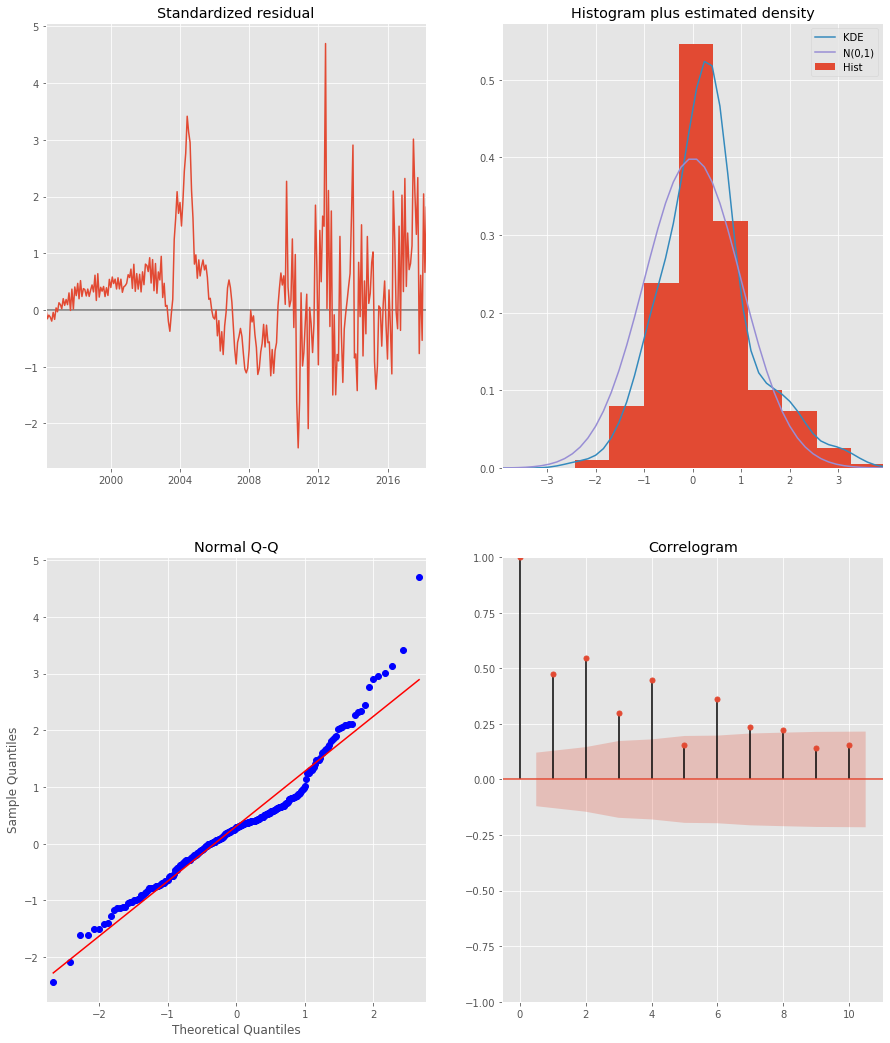

In [36]:
output_1053.plot_diagnostics(figsize=(15, 18))
plt.show()

The outputs aren't great but not awful, the correlogram indicates that this model could probably be improved by moving to a higher order, but computation time on this computer isn't going to get us there very quickly!

In [37]:
pred = output.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False, full_results=True)
pred_conf = pred.conf_int()

In [38]:
# Get the real and predicted values
df_1053_forecasted = pred.predicted_mean
df_1053_truth = df_1053['1996-04-01':]

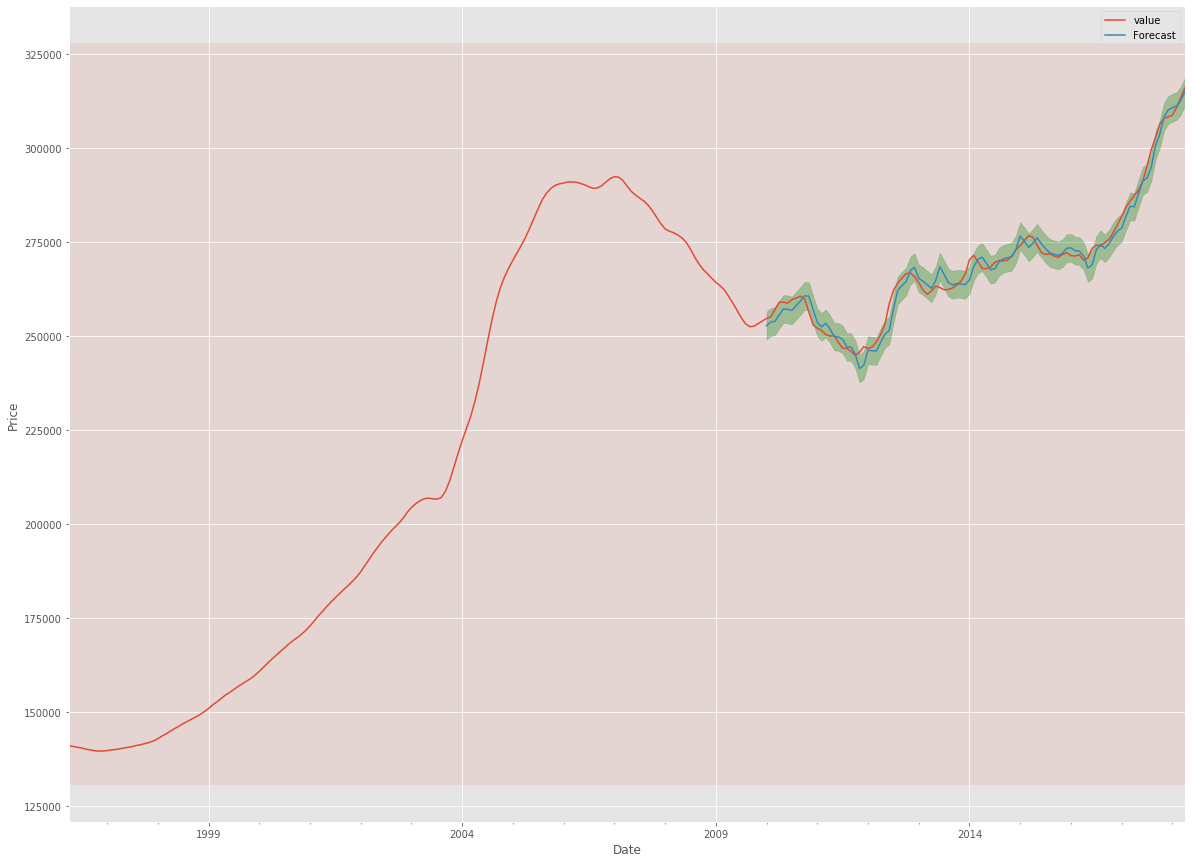

In [39]:
# Plot the dynamic forecast with confidence intervals.

ax = df_1053['1996':].plot(label='observed', figsize=(20, 15))
pred.predicted_mean.plot(label='Forecast', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1996-04-01'), df_1053_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

Looks like it does a pretty good job of modelling the values inside the known set of values 

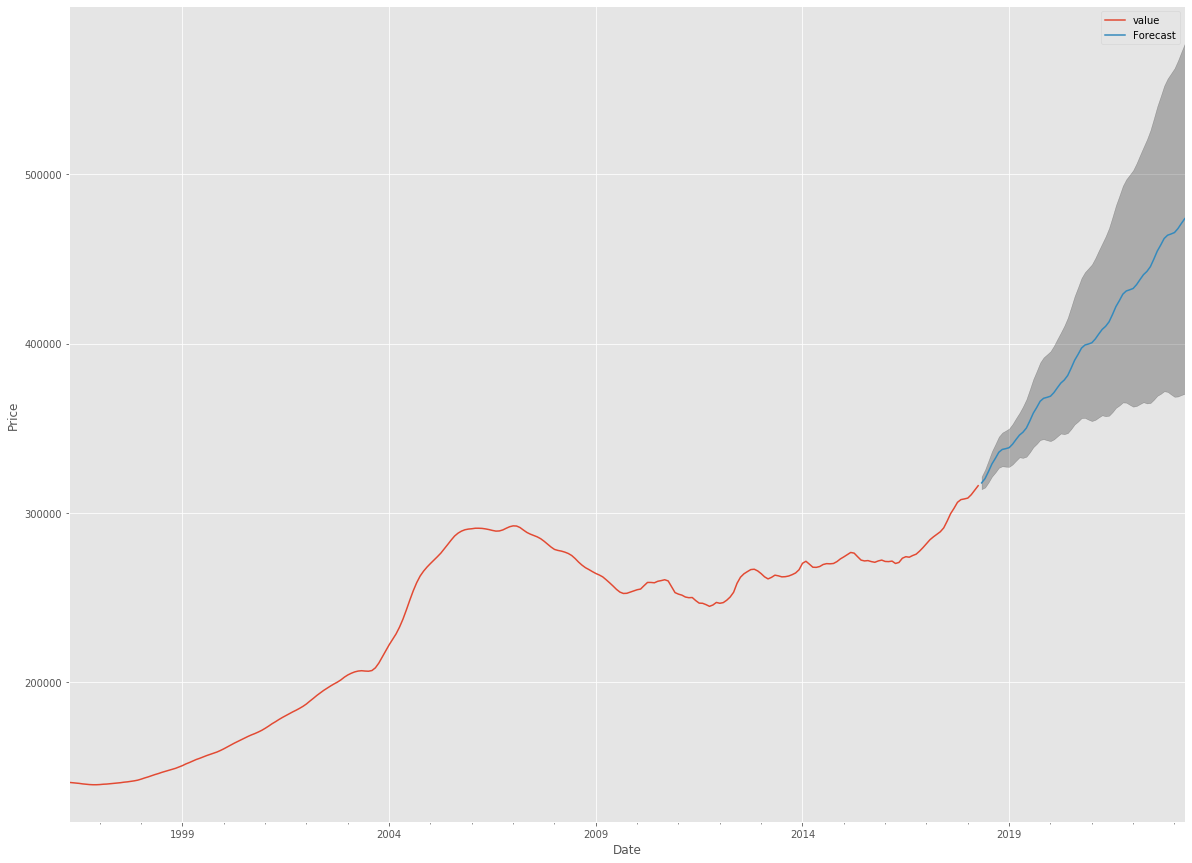

In [40]:
# Get forecast 60 steps ahead in future
prediction = output.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = df_1053.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

This model predicts a big rise in prices in this neighbourhood, which is what we are looking for! 

Should I be having a look at all of the top neighbourhoods like this to check that the models are ok? Seems a bit messy 